# Imports

In [3]:
%load_ext autoreload
%autoreload 2

import os
import subprocess
import sys
import warnings

warnings.simplefilter("ignore", FutureWarning)

import xclone_config
project_config = xclone_config
os.chdir(project_config.ROOT)

from collections import defaultdict, OrderedDict
import multiprocessing as mp
import sys

import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

from data_types import ase
import plotlib
import toolkit
import util
import test_phasing
from workspace.workspace_manager import WorkspaceManager

workspace = WorkspaceManager(
    task_name="preprocessing",
    experiment_info={"modality" : "scDNA", 
                     "sample" : "STP_G&T"},
    verbose=True
)
workspace.load_workspace()

sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Description

If phasing is valid, we expect ASE profiles to agree with CNV profiles. However, we didn't assert that.  
We know for sure, that there is a deletion of 3p arm in most of the cells of the first sample. Also, some cells are clearly polyploid.  
The goal of this notebook is to use this information by implementing sanity-checks for our expression datasets.

To do so, we will select genes that from regions with unusual CNV status.  
Then, for each gene (or group of genes) we will divide cells into three groups: **loss**, **gain** and **wildtype** (doesn't change from gene to gene).  
For each individual cell, we will compute the ASE ratios for genes/SNPs and plot those.

# Implementation

In [2]:
requirements = ["raw_counts", "clustering", 
                "genome", "gene_to_snps", 
                "gene_counts"]

data = {
    dtype : 
    util.pickle_load(workspace.tmp_data[dtype])
    for dtype in tqdm_notebook(
        requirements,
        "loading datasets into RAM"
    )
}

data["cnv"] = pd.read_csv(
    f"{project_config.MB_RAW}/first_sample/scDNA/cnv.tsv",
    sep='\t'
)
data["cnv"].index = np.vstack(
    data["cnv"].index.str.split("_")
)[:, 1].astype(int)
data["cnv"].sort_index(inplace=True)
# dropping noisy cells out
data["cnv"] = data["cnv"][
    data["cnv"].index.isin(
        data["clustering"]["CELL_ID"]
    )
].reset_index(drop=True)
data["non_merged_genome"] = pd.read_csv(
    "/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference"
    "/data/raw/non_merged_hg19.csv"
)

data_name = workspace.experiment_info['data']
sample_name = workspace.experiment_info['sample']
clustering_name = "evo_dist_9"
print(f"Currently working on {data_name}, {sample_name}")


Currently working on scDNA, first_sample


In [3]:
genes_on_3p = [
    "ALAS1", "APEH", "ARPP-21", "AZI2",
    "BRK1", "BRPF1", "BTD", 
    "C3orf14", "C3orf23", "C3orf60", "CACNA2D3", 
    "CCR5", "CGGBP1", "CMTM7", "CNTN4", "COL7A1", "CRBN",
    "DCLK3",
    "ENTPD3", 
    "FAM107A", "FAM19A1", "FBXL2", "FOXP1", "FRA3A", "FRMD4B",
    "GMPPB", 
    "HEMK1", "HIGD1A", 
    "LARS2", "LIMD1", "LINC00312",
    "MITF", "MLH1", "MYRIP", 
    "NBEAL2", "NKTR", "NPRL2", 
    "OXTR", 
    "PHF7", "PTHR1",
    "QRICH1", 
    "RBM6", "RPP14", 
    "SCN5A", "SETD5", "SFMBT1", "SLC25A20", "STT3B", "SYNPR",
    "TDFG1", "TMEM158", "TMIE", "TRAK1", "TRANK1",
    "UCN2", "ULK4", 
    "VGLL3", "VHL", 
    "ZMYND10", "ZNF502", "ZNF621"
]

,threshold,fraction of genes below threshold
0,0.01,0.027355
1,0.02,0.027355
2,0.03,0.027355
3,0.04,0.027355
4,0.05,0.027355
5,0.06,0.027355
6,0.07,0.027444
7,0.08,0.027444
8,0.09,0.027444
9,0.10,0.027444


Threshold fraction value: 0.25


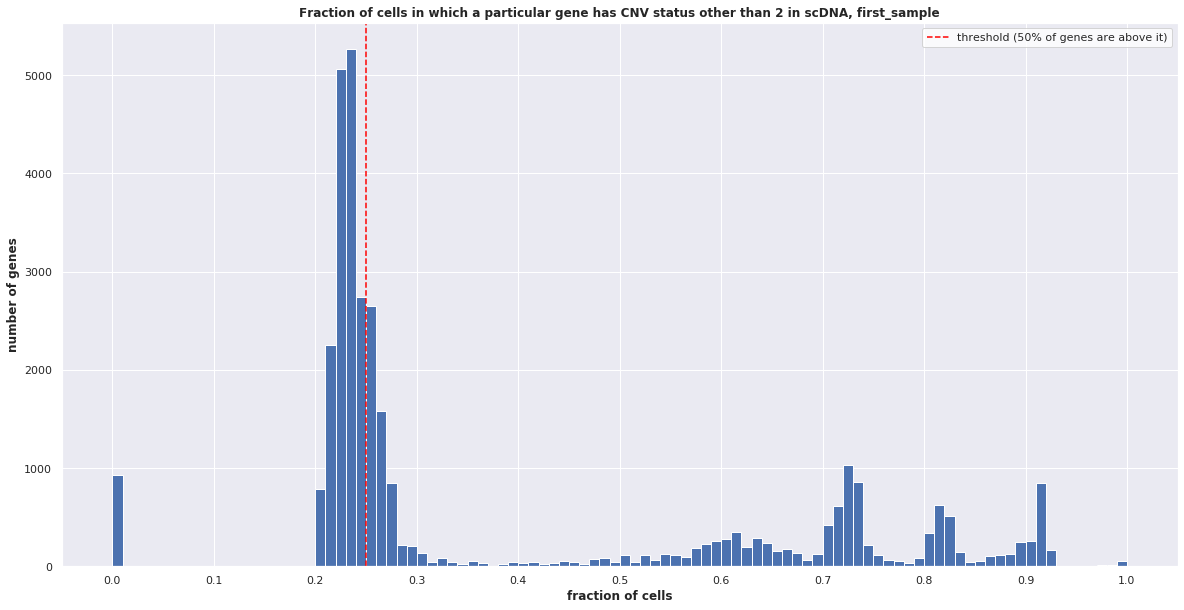

In [4]:
with sns.plotting_context(font_scale=1.5):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_title(
        "Fraction of cells in which a particular gene"
        f" has CNV status other than 2 in {data_name}, {sample_name}",
        weight="bold"
    )
    ax.set_xlabel("fraction of cells", weight="bold")
    ax.set_xticks(np.linspace(0,1,11))
    ax.set_ylabel("number of genes", weight="bold")
    
    nonstandard_cnv_fraction = ((data["cnv"] < 2) 
                                | (data["cnv"] > 2)).mean(axis=0)
    hist_bins = np.linspace(0,1,101)
    nonstandard_cnv_fraction_df = \
        pd.DataFrame(
            np.column_stack((
                hist_bins[1:],
                np.histogram(
                    nonstandard_cnv_fraction, 
                    bins=hist_bins
                )[0].cumsum() / data["cnv"].shape[1]
            )),
            columns=["threshold", "fraction of genes below threshold"]
        )
    display(nonstandard_cnv_fraction_df)
    threshold = nonstandard_cnv_fraction_df[
        nonstandard_cnv_fraction_df[
            "fraction of genes below threshold"
        ] >= 0.5
    ].iloc[0]["threshold"]
    print(f"Threshold fraction value: {threshold}")

    nonstandard_cnv_fraction.hist(
        ax=ax,
        bins=hist_bins
    )
    ax.axvline(
        threshold, 
        linestyle="--", 
        color="red", 
        label="threshold (50% of genes are above it)"
    )
    ax.legend().get_frame().set_facecolor("white")

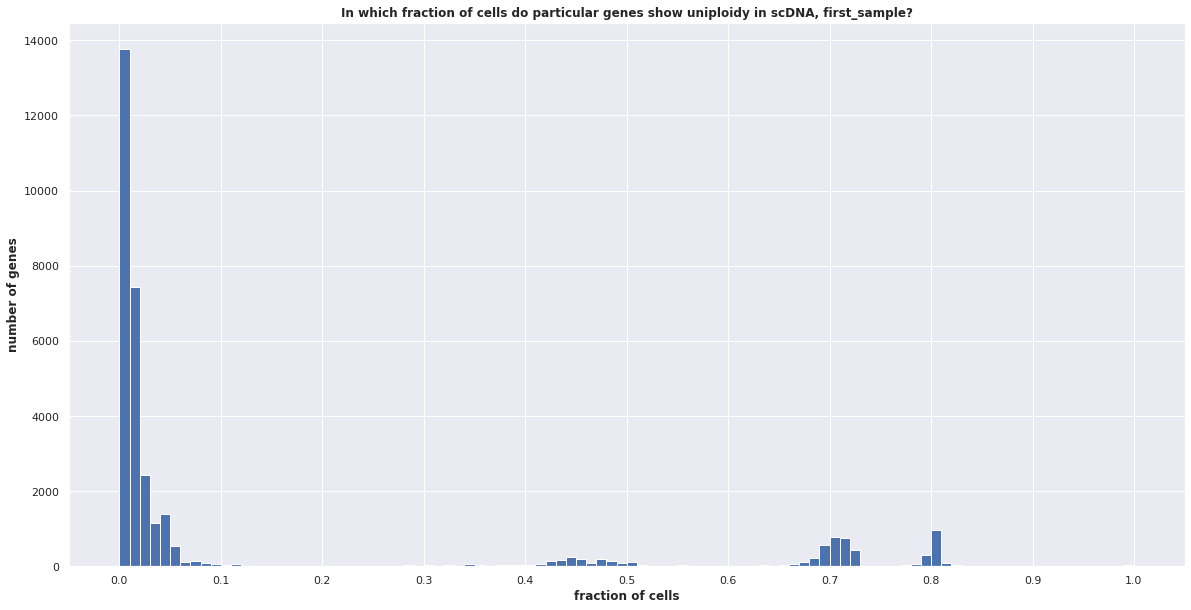

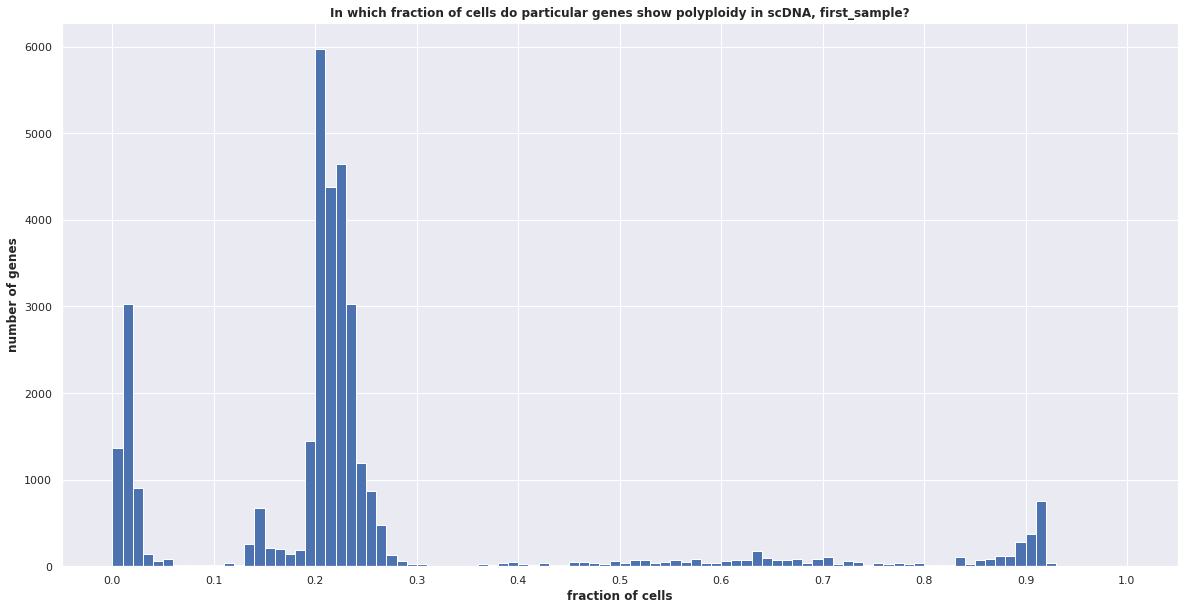

In [5]:
with sns.plotting_context(font_scale=1.5):
    for ploidy_type, ploidy_condition in zip(
        ["uniploidy", "polyploidy"], 
        [lambda x: x <= 1, lambda x: x >= 3]
    ):
        fig, ax = plt.subplots(figsize=(20,10))
        ax.set_title(
            "In which fraction of cells do particular genes show"
            f" {ploidy_type} in {data_name}, {sample_name}?",
            weight="bold"
        )
        ax.set_xlabel("fraction of cells", weight="bold")
        ax.set_xticks(np.linspace(0,1,11))
        ax.set_ylabel("number of genes", weight="bold")
        data["cnv"].apply(ploidy_condition).mean(axis=0).hist(
            ax=ax, 
            bins=np.linspace(0,1,101)
        )

In [6]:
true_wild_type = data["clustering"].query("LABEL == 8")

In [9]:
# quantile = "90%"
# norm_summary = data["scoring"]\
#                 .NORM\
#                 .describe(percentiles=np.arange(0,1,0.05))

# top_gene_ids = data["scoring"][
#     data["scoring"].NORM > norm_summary[quantile]
# ].GENE_ID
id_to_name = dict(data["genome"][["GENE_ID", "GENE_NAME"]].values)
top_gene_names = genes_on_3p
# top_gene_names = [id_to_name.get(gene_id) 
#                   for gene_id in np.intersect1d(top_gene_ids, 
#                                                 data["genome"]["GENE_ID"])]

# data["scoring"]["ABOVE_THRESHOLD"] = 0
# data["scoring"]["ABOVE_THRESHOLD"][top_genes.index] = 1

# print(f"Selected pool of {len(top_genes)} genes")

In [12]:
for gene in tqdm_notebook(top_gene_names, "gene"):#data["genome"]["GENE_NAME"], "gene"):
    ensembl = data["genome"][
        data["genome"]["GENE_NAME"] == gene
    ]["GENE_ID"].values
    
    if len(ensembl) != 1:
#         print(f"gene {gene} has no reads mapped")
        continue
        
#     assert len(ensembl) == 1,\
#             "Ambiguous gene name (more than one ENSEMBL entries)"
    
    cnv_mask = {
        "loss" : (data["cnv"][ensembl] < 2).values,
        "gain" : (data["cnv"][ensembl] > 2).values
    }
        
    cells_fraction = {
        cnv_status : cnv_mask[cnv_status].mean(axis=0)
        for cnv_status in ["loss", "gain"]
    }
    
    if np.all(np.fromiter(cells_fraction.values(), dtype=float) < threshold):
        continue
        
#     print(f"{ensembl}, threshold of {threshold}:"
#           f"\n\t-loss: {cells_fraction['loss']}"
#           f"\n\t-gain: {cells_fraction['gain']}")
    
#     assert cells_fraction['loss'] >= threshold,\
#           "There is a deletion of 3p in most cells!"
    
    true_clustering = data["clustering"].copy()
    try:
        data["clustering"]["LABEL"] = np.nan
    #     display(data["clustering"])
        for cnv_status in ["loss", "gain"]:
            if cells_fraction[cnv_status] < threshold:
                continue
            for i in np.where(cnv_mask[cnv_status]):
                data["clustering"]["LABEL"].loc[i] = cnv_status
        for i in true_wild_type["CELL_ID"]:
              data["clustering"]["LABEL"].loc[i-1] = "wt"
        data["clustering"].dropna(inplace=True)
        ordering = {
            "loss" : 1,
            "wt" : 2,
            "gain" : 3
        }
        data["clustering"]["LABEL"] = data["clustering"]["LABEL"].apply(
            lambda label: f"{ordering[label]}_{label}"
        )
        test_phasing.test_deletion_ase_for_snps(
            [gene],
            data,
            tags={
                "data" : data_name,
                "sample" : sample_name,
                "clustering" : "[loss, wt, gain]"
            },
            img_dir=f"{workspace.img_dir}/scDNA"\
                    "/phasing_tests/clustering_by_cnv/snps/3p/haplotype_blocks"
        )
    finally:
          data["clustering"] = true_clustering.copy()

In [11]:
data["non_merged_genome"]

,CHROM,START,END,GENE_NAME,GENE_ID
0,1,11869,14412,DDX11L1,ENSG00000223972
1,1,14363,29806,WASH7P,ENSG00000227232
2,1,29554,31109,MIR1302-10,ENSG00000243485
3,1,34554,36081,FAM138A,ENSG00000237613
4,1,52473,54936,OR4G4P,ENSG00000268020
5,1,62948,63887,OR4G11P,ENSG00000240361
6,1,69091,70008,OR4F5,ENSG00000186092
7,1,89295,133566,RP11-34P13.7,ENSG00000238009
8,1,89551,91105,RP11-34P13.8,ENSG00000239945
9,1,131025,134836,CICP27,ENSG00000233750


limit_output extension: Maximum message size of 10000 exceeded with 10073 characters